In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

from decifer.decifer_dataset import DeciferDataset
from decifer.decifer_model import Decifer, DeciferConfig
from decifer.tokenizer import Tokenizer
from bin.evaluate import extract_prompt, load_model_from_checkpoint
from decifer.utility import (
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
    disc_to_cont_xrd,
    disc_to_cont_xrd_from_cif,
)

# Load your dataset
dataset = DeciferDataset('../data/crystallm/full/serialized/test.h5', ['cif_string', 'cif_tokenized', 'xrd_disc.q', 'xrd_disc.iq'])
dataset_iter = iter(dataset)

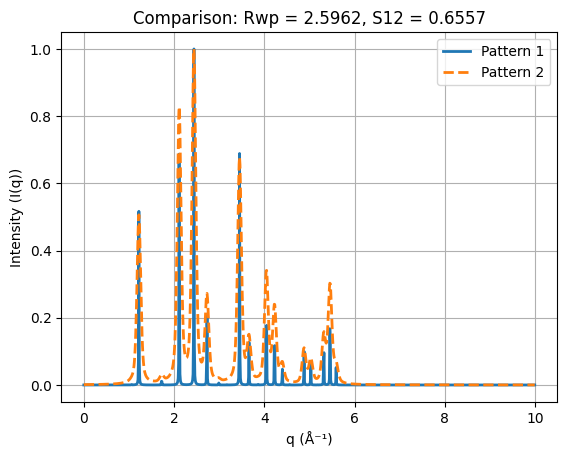

In [23]:
# Fetch two samples
out1 = next(dataset_iter)
out2 = next(dataset_iter)

# Extract CIF and XRD data for both samples
xrd_disc_q1, xrd_disc_iq1 = out1['xrd_disc.q'], out1['xrd_disc.iq']

# Convert discrete XRD to continuous patterns
xrd_out1 = disc_to_cont_xrd(
    xrd_disc_q1.unsqueeze(0), xrd_disc_iq1.unsqueeze(0),
    qmin=0.0, qmax=10.0, qstep=0.01,
    fwhm_range=(0.01, 0.01), noise_range=(0.00, 0.00),
    mask_prob=0.0, intensity_scale_range=(1.0, 1.0)
)
xrd_out2 = disc_to_cont_xrd(
    xrd_disc_q1.unsqueeze(0), xrd_disc_iq1.unsqueeze(0),
    qmin=0.0, qmax=10.0, qstep=0.01,
    fwhm_range=(0.1, 0.1), noise_range=(0.00, 0.00),
    mask_prob=0.0, intensity_scale_range=(1.0, 1.0)
)

# Extract intensity (iq) and q values
iq1, q1 = xrd_out1['iq'].squeeze().numpy(), xrd_out1['q'].squeeze().numpy()
iq2, q2 = xrd_out2['iq'].squeeze().numpy(), xrd_out2['q'].squeeze().numpy()

# Function to calculate Rwp
def calculate_rwp(obs, calc):
    residual = obs - calc
    numerator = np.sum(residual ** 2)
    denominator = np.sum(obs ** 2)
    return np.sqrt(numerator / denominator)

# Function to calculate generalized similarity S12
def generalized_similarity(y1, y2, l, s_range):
    def triangular_weighting(s, l):
        return np.maximum(0, 1 - np.abs(s) / l)
    
    def cross_correlation(y1, y2, s_range):
        return [np.sum(y1 * np.roll(y2, shift)) for shift in s_range]

    c12 = cross_correlation(y1, y2, s_range)
    c11 = cross_correlation(y1, y1, s_range)
    c22 = cross_correlation(y2, y2, s_range)

    weights = triangular_weighting(s_range, l)
    weighted_c12 = weights * c12
    weighted_c11 = weights * c11
    weighted_c22 = weights * c22

    numerator = simpson(weighted_c12, x=s_range)
    denominator = np.sqrt(simpson(weighted_c11, x=s_range) * simpson(weighted_c22, x=s_range))
    return numerator / denominator if denominator != 0 else 0

# Calculate Rwp and S12 for the two patterns
rwp = calculate_rwp(iq1, iq2)
s12 = generalized_similarity(iq1, iq2, l=2, s_range=np.arange(-50, 51))

# Plot the two XRD patterns
plt.plot(q1, iq1, label='Pattern 1', linewidth=2)
plt.plot(q2, iq2, label='Pattern 2', linestyle='--', linewidth=2)
plt.xlabel('q (Å⁻¹)')
plt.ylabel('Intensity (I(q))')
plt.legend()
plt.title(f'Comparison: Rwp = {rwp:.4f}, S12 = {s12:.4f}')
plt.grid(True)
plt.show()



In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from fastdtw import fastdtw
from scipy.spatial.distance import directed_hausdorff, euclidean
from scipy.spatial import cKDTree

# Load your dataset
dataset = DeciferDataset('../data/crystallm/full/serialized/test.h5', ['cif_string', 'cif_tokenized', 'xrd_disc.q', 'xrd_disc.iq'])
dataset_iter = iter(dataset)

Wasserstein distance: 0.05
Hausdorff distance: 0.23
Nearest neighbor mean distance: 0.00


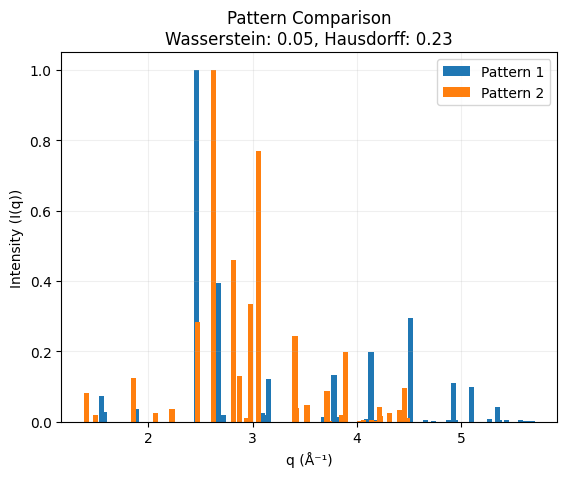

In [57]:
# Fetch two samples directly from the dataset
out1 = next(dataset_iter)
out2 = next(dataset_iter)

# Extract the discrete XRD data directly
q1, iq1 = out1['xrd_disc.q'].numpy(), out1['xrd_disc.iq'].numpy()
# q2, iq2 = q1, iq1
q2, iq2 = out2['xrd_disc.q'].numpy(), out2['xrd_disc.iq'].numpy()

# Ensure that the lengths of q1 and q2 match by padding or truncating (if necessary)
min_len = min(len(q1), len(q2))
q1, iq1 = q1[:min_len], iq1[:min_len]
q2, iq2 = q2[:min_len], iq2[:min_len]

# --- Method 1: Earth Mover’s Distance (Wasserstein) ---
emd_distance = wasserstein_distance(iq1, iq2)
print(f'Wasserstein distance: {emd_distance:.2f}')

# --- Method 3: Hausdorff Distance ---
iq1_reshaped = iq1.reshape(-1, 1)
iq2_reshaped = iq2.reshape(-1, 1)

hausdorff_distance = max(
    directed_hausdorff(iq1_reshaped, iq2_reshaped)[0],
    directed_hausdorff(iq2_reshaped, iq1_reshaped)[0]
)
print(f'Hausdorff distance: {hausdorff_distance:.2f}')

# --- Method 4: Nearest Neighbors Matching ---
def match_peaks(peaks1, peaks2):
    tree = cKDTree(peaks2[:, None])
    distances, indices = tree.query(peaks1[:, None])
    return distances

nearest_neighbor_distances = match_peaks(iq1, iq2)
mean_nn_distance = np.mean(nearest_neighbor_distances)
print(f'Nearest neighbor mean distance: {mean_nn_distance:.2f}')

# --- Plotting the two discrete XRD patterns ---
plt.bar(q1, iq1, label='Pattern 1', linewidth=2, width=0.05)
plt.bar(q2, iq2, label='Pattern 2', linestyle='--', linewidth=2, width=0.05)
plt.xlabel('q (Å⁻¹)')
plt.ylabel('Intensity (I(q))')
plt.legend()
plt.title(f'Pattern Comparison\nWasserstein: {emd_distance:.2f}, Hausdorff: {hausdorff_distance:.2f}')
plt.grid(alpha=0.2)
plt.show()
